## Understanding Variational Auto-Encoders

A notebook that explores the basic ideas behind VAEs

In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
%matplotlib inline

np.random.seed(0)

Using TensorFlow backend.


In [3]:
"""
First, lets look at a standard autoencoder.
Demonstrated through the fashion mnist dataset
"""
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.
x_test = x_test / 255.
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [0]:
"""
Define the architecture of the network:
input layer -> 3 hidden layers -> output layer
that means 4 weight matrices and 4 biases
"""

n_input = 784  # input layer (28x28 pixels)
n_hidden1 = 128  # 1st hidden layer
n_hidden2 = 16  # 2nd hidden layer
n_hidden3 = 128  # 3rd hidden layer
n_output = 784  # output layer (0-9 digits)


# define hyperparameters 
learning_rate = 1e-4
n_iterations = 1000
batch_size = 128
# dropout = 0.5
display_freq = 100

# The main part: 
X = tf.placeholder("float", [None, n_input], name='X')
Y = tf.placeholder("float", [None, n_output], name='Y')
keep_prob = tf.placeholder(tf.float32)

weights = {
    'w1': tf.Variable(tf.truncated_normal([n_input, n_hidden1], stddev=0.1)),
    'w2': tf.Variable(tf.truncated_normal([n_hidden1, n_hidden2], stddev=0.1)),
    'w3': tf.Variable(tf.truncated_normal([n_hidden2, n_hidden3], stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([n_hidden3, n_output], stddev=0.1)),
}

biases = {
    'b1': tf.Variable(tf.constant(0.0, shape=[n_hidden1])),
    'b2': tf.Variable(tf.constant(0.0, shape=[n_hidden2])),
    'b3': tf.Variable(tf.constant(0.0, shape=[n_hidden3])),
    'out': tf.Variable(tf.constant(0.0, shape=[n_output]))
}

# define the graph
# TODO: add activation functions
layer_1 = tf.nn.relu(tf.add(tf.matmul(X, weights['w1']), biases['b1']))
layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['w2']), biases['b2']))
layer_3 = tf.nn.relu(tf.add(tf.matmul(layer_2, weights['w3']), biases['b3']))
# layer_drop = tf.nn.dropout(layer_3, rate=1-keep_prob)
output = tf.matmul(layer_3, weights['out']) + biases['out']

loss = tf.reduce_mean(
                tf.losses.mean_squared_error(labels=Y, predictions=output))
train_step = tf.train.AdamOptimizer().minimize(loss)

In [0]:
cost = tf.reduce_mean(tf.cast(tf.losses.mean_squared_error(labels=Y, predictions=output), tf.float32))

epoch 0, MSE=0.02152159810066223
epoch 1, MSE=0.02010122314095497
epoch 2, MSE=0.01889711618423462
epoch 3, MSE=0.018310699611902237
epoch 4, MSE=0.017833715304732323
epoch 5, MSE=0.016953712329268456
epoch 6, MSE=0.016695812344551086
epoch 7, MSE=0.016513291746377945
epoch 8, MSE=0.016417106613516808
epoch 9, MSE=0.016228588297963142
(1, 784)


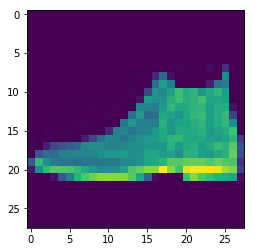

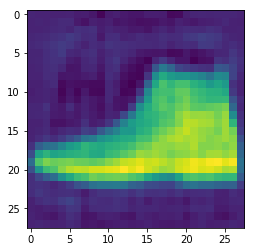

In [81]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for j in range(10): # number of epochs
        for i in range(0, x_train.shape[0], 32):
            x_batch = x_train[i:i+32]
            _, mse = sess.run([train_step, cost], feed_dict={X: x_batch, Y: x_batch})
        print('epoch {}, MSE={}'.format(j, mse))
        
    sample_img = np.expand_dims(x_test[0], axis=0)
    pred = sess.run(output, feed_dict={X:sample_img})
    print(pred.shape)
    img = np.reshape(sample_img, (28,28))
    pred = np.reshape(pred, (28,28))
    plt.imshow(img)
    plt.figure()
    plt.imshow(pred)


In [0]:
img1 = np.expand_dims(x_train[0],axis=0)
img2 = np.expand_dims(x_train[1], axis=0)
plt.imshow(img1.reshape(28,28))
plt.figure()
plt.imshow(img2.reshape(28,28))

training_data = tf.placeholder(tf.float32, [None, x_train.shape[1]])
labels = tf.placeholder(tf.float32, [None, x_train.shape[1]])

output = training_data + labels

with tf.Session() as sess:
    print(img1.shape, img2.shape)
    print(training_data.shape)
    ret = sess.run([output], feed_dict={training_data: img1, labels: img2})
    print(ret[0].shape)
    plt.figure()
    plt.imshow(ret[0].reshape(28,28))

In [47]:
"""
Lets first verify the number of layers and activations needed for auto enc
"""
import keras
model = keras.Sequential()
model.add(keras.layers.Dense(128, input_shape=(x_train.shape[1],), activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(784))
model.compile(loss='mse', optimizer='adam')
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total params: 205,856
Trainable params: 205,856
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(x_train, x_train, epochs=10, verbose=1,)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 8s 126us/step - loss: 0.0264
Epoch 2/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.0205
Epoch 3/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.0194
Epoch 4/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.0185
Epoch 5/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.0181
Epoch 6/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.0179
Epoch 7/10
60000/60000 [==============================] - 6s 107us/step - loss: 0.0177
Epoch 8/10
60000/60000 [==============================] - 6s 108us/step - loss: 0.0175
Epoch 9/10
60000/60000 [==============================] - 7s 117us/step - loss: 0.0174
Epoch 10/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.0173


In [0]:
pred = model.predict(x_test)

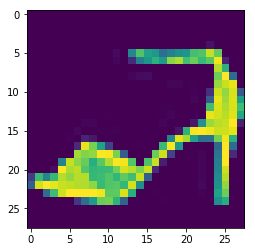

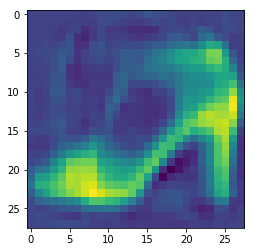

In [58]:
idx = np.random.randint(0, x_test.shape[0])
img_in = np.reshape(x_test[idx], (28,28))
img_out = np.reshape(pred[idx], [28,28])
plt.imshow(img_in)
plt.figure()
plt.imshow(img_out)

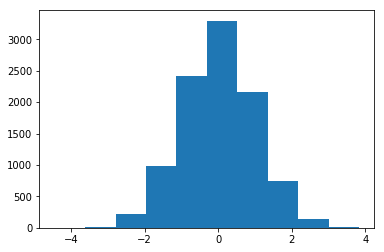

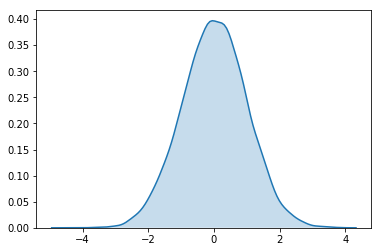

In [0]:
"""
Intermission: sampling from a distribution
"""
nsamples = 10000
y = np.random.np.random.normal(0,1,nsamples)
x = np.linspace(-10, 10, nsamples)

# plt.plot(y, x, '.')
plt.hist(y)
plt.figure()
sns.kdeplot(data=y, shade=True)